In [42]:
import cv2
from sklearn.neural_network import MLPClassifier  # MLP is an NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tqdm import tqdm
import random
import pickle
from my_commonfunctions import *
from Remove_Staff_Lines import *

In [2]:
path_to_dataset = r'Symbols/data'
target_img_size = (32, 32)

random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
def load_dataset():
    imgs = []
    labels = []
    for cf in os.listdir(path_to_dataset):
        try:
            for fn in tqdm(os.listdir(path_to_dataset+'/'+cf), desc=cf):
                img = cv2.imread(path_to_dataset+'/'+cf+'/'+fn)
                imgs.append(img)
                labels.append(cf)
        except:
            print('\r'+cf+' Probably not a folder ....')
    
    return imgs, labels

In [4]:
imgs, labels = load_dataset()

treple_clef: 100%|██████████| 392/392 [00:02<00:00, 156.53it/s]
.DS_Store Probably not a folder ....
double_sharp_accidental: 100%|██████████| 391/391 [00:00<00:00, 456.42it/s]


In [5]:
def extract_raw_pixels(img):
    """
    TODO
    The classification algorithms we are going to use expect the input to be a vector not a matrix. 
    This is because they are general purpose and don't work only on images.
    CNNs, on the other hand, expect matrices since they operate on images and exploit the 
    arrangement of pixels in the 2-D space.
    
    So, what we only need to do in this function is to resize and flatten the image.
    """
    img = cv2.resize(img, target_img_size)
    return img.flatten()

In [6]:
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [7]:
def extract_features(img, feature_set='hog'):
    """
    TODO
    Given either 'hog', 'raw', call the respective function and return its output
    """
    if feature_set == 'hog':
        return extract_hog_features(img)
    elif feature_set == 'raw':
        return extract_raw_pixels(img)

In [19]:
def extract_features_for_all(imgs, feature_set='hog'):
    features = []

    for i, img in enumerate(tqdm(imgs)):
        try:
            features.append(extract_features(img, feature_set))
        except:
            print(img)
            del labels[i]
    
    return features

In [9]:
classifiers = {
    'SVM': svm.LinearSVC(random_state=random_seed),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'NN': MLPClassifier(solver='sgd', random_state=random_seed, hidden_layer_sizes=(500,), max_iter=20, verbose=1)
}

In [20]:
features = extract_features_for_all(imgs, 'hog')

100%|██████████| 8230/8230 [00:04<00:00, 1842.61it/s]


In [14]:
# This function will test all our classifiers on a specific feature set
def train(features, labels, model):
    
    # Since we don't want to know the performance of our classifier on images it has seen before
    # we are going to withhold some images that we will test the classifier on after training 
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)
    
    print('Training .........')

    # Train the model only on the training features
    model.fit(train_features, train_labels)
    
    # Test the model on images it hasn't seen before
    accuracy = model.score(test_features, test_labels)
    
    print('accuracy:', accuracy*100, '%')
    

In [21]:
train(features, labels, classifiers['SVM'])

Training .........
accuracy: 100.0 %


In [191]:
with open('svm.pkl', 'wb') as fid:
    pickle.dump(classifiers['SVM'], fid)

In [61]:
?pickle.dumps

Signature: pickle.dumps(obj, protocol=None, *, fix_imports=True)
Docstring:
Return the pickled representation of the object as a bytes object.

The optional *protocol* argument tells the pickler to use the given
protocol; supported protocols are 0, 1, 2, 3 and 4.  The default
protocol is 3; a backward-incompatible protocol designed for Python 3.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

If *fix_imports* is True and *protocol* is less than 3, pickle will
try to map the new Python 3 names to the old module names used in
Python 2, so that the pickle data stream is readable with Python 2.
Type:      builtin_function_or_method


In [44]:
def add_padding(img_gray, ww, hh, color):
    ht, wd = img_gray.shape[:2]

    # create new image of desired size and color (blue) for padding
    result = np.full((hh, ww), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = img_gray

    return result

In [127]:
def zoom_in(staff_lines_removed):
    staff_lines_removed = np.ascontiguousarray(staff_lines_removed)
    test_copy = cv2.dilate(staff_lines_removed, np.ones((5, 5)))

    image, contours, hierarchy = cv2.findContours(test_copy,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #contours_drawn = gray2rgb(np.copy(test_copy))
    max_area_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_area_contour)
    zoomed_in = np.copy(staff_lines_removed[y:y+h, x:x+w])

    return zoomed_in

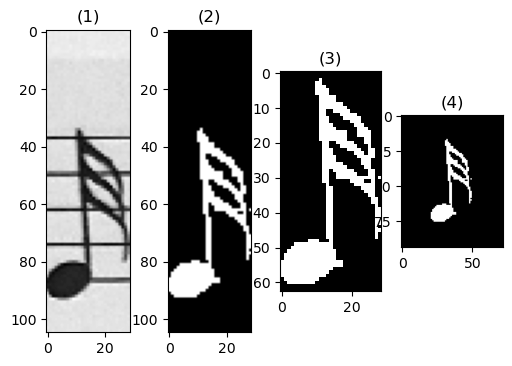

In [188]:
test = my_imread_gray('shubra1/out6.png')
staff_lines_removed = remove_staff_lines(test)
zoomed_in = zoom_in(staff_lines_removed)
zoomed_in_padding = add_padding(zoomed_in, ww=int(zoomed_in.shape[1]*2.5), hh=int(zoomed_in.shape[0]*1.5), color=0)
my_show_images([test, staff_lines_removed, zoomed_in, zoomed_in_padding], dpi=100, row_max=4)

In [189]:
staff_lines_removed_features = extract_features(zoomed_in_padding, 'hog')
classifiers['SVM'].predict([staff_lines_removed_features])

array(['thirty_second_note'], dtype='<U30')

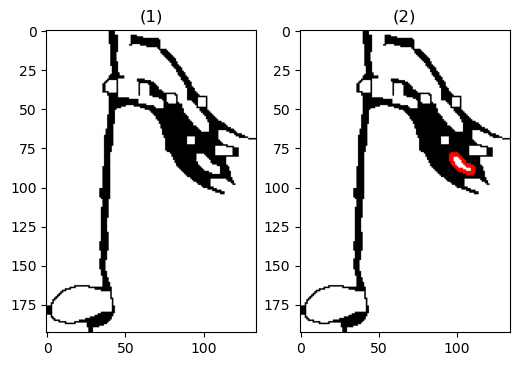

In [187]:
thresh = cv2.adaptiveThreshold(255-zoomed_in, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)
thresh = my_open(thresh, np.ones((5, 5)))
image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours_drawn = gray2rgb(np.copy(thresh))
contours_drawn = cv2.drawContours(contours_drawn, contours[2], -1, (255, 0, 0), 2)

my_show_images([thresh, contours_drawn], dpi=100, row_max=2)

In [179]:
?cv2.drawContours

Docstring:
drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset]]]]]) -> image
.   @brief Draws contours outlines or filled contours.
.   
.   The function draws contour outlines in the image if \f$\texttt{thickness} \ge 0\f$ or fills the area
.   bounded by the contours if \f$\texttt{thickness}<0\f$ . The example below shows how to retrieve
.   connected components from the binary image and label them: :
.   @include snippets/imgproc_drawContours.cpp
.   
.   @param image Destination image.
.   @param contours All the input contours. Each contour is stored as a point vector.
.   @param contourIdx Parameter indicating a contour to draw. If it is negative, all the contours are drawn.
.   @param color Color of the contours.
.   @param thickness Thickness of lines the contours are drawn with. If it is negative (for example,
.   thickness=#FILLED ), the contour interiors are drawn.
.   @param lineType Line connectivity. See #LineTypes
.   @